<a href="https://colab.research.google.com/github/Nikhil-Khetani/Tesla-Stock-Price-Predictor/blob/main/Notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler


style.use('ggplot')

num_epochs = 100
input_length = 10
batch_size = 16


start = datetime(2011, 1, 1)
end = datetime(2021, 1, 1)

df = web.DataReader('TSLA', 'yahoo', start, end).reset_index(level=0)
'''
df.to_csv('tsla.csv')

df = pd.read_csv('tsla.csv', index_col=0).reset_index()
'''
df.head()


,Date,High,Low,Open,Close,Volume,Adj Close
0,2011-01-03,5.400,5.180,5.368,5.324,6415000.0,5.324
1,2011-01-04,5.390,5.204,5.332,5.334,5937000.0,5.334
2,2011-01-05,5.380,5.238,5.296,5.366,7233500.0,5.366
3,2011-01-06,5.600,5.362,5.366,5.576,10306000.0,5.576
4,2011-01-07,5.716,5.580,5.600,5.648,11239500.0,5.648


In [ ]:
df = pd.DataFrame(df[['Date','Adj Close']])
df['Date']=pd.to_datetime(df['Date'])
df.head()

,Date,Adj Close
0,2011-01-03,5.324
1,2011-01-04,5.334
2,2011-01-05,5.366
3,2011-01-06,5.576
4,2011-01-07,5.648


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2517 non-null   datetime64[ns]
 1   Adj Close  2517 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df['2015'].head()

,Adj Close
Date,
2015-01-02,43.862000
2015-01-05,42.018002
2015-01-06,42.256001
2015-01-07,42.189999
2015-01-08,42.124001


In [ ]:
date_range = df.index.max()-df.index.min()
print(date_range)

3650 days 00:00:00


In [ ]:
new_index = pd.date_range(df.index.min(),df.index.max())
df = df.reindex(new_index)

In [ ]:
df['Adj Close'].value_counts(dropna=False)

NaN          1134
5.484000        4
42.018002       3
5.424000        3
6.492000        3
             ... 
56.366001       1
48.292000       1
42.888000       1
39.209999       1
49.548000       1
Name: Adj Close, Length: 2354, dtype: int64

In [ ]:
df['Adj Close'].interpolate(method='linear', inplace=True)

In [ ]:
df['Adj Close'].value_counts(dropna=False)


5.484000     4
5.634000     3
6.492000     3
5.320000     3
42.018002    3
            ..
45.557999    1
4.748500     1
34.335499    1
25.804000    1
6.750000     1
Name: Adj Close, Length: 3471, dtype: int64

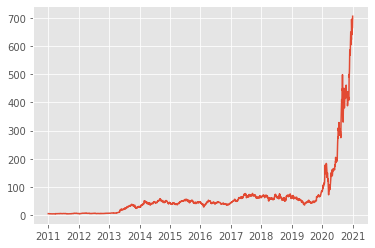

In [ ]:
plt.plot(df)

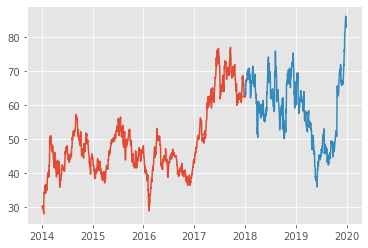

In [ ]:
train_data = pd.DataFrame(df['2014':'2017'])
test_data = df['2018':'2019']

plt.plot(train_data)
plt.plot(test_data)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_scaled = scaler.fit_transform(train_data)

In [ ]:
train_data['Scaled_close'] = train_data_scaled
train_data_scaled = pd.DataFrame(train_data['Scaled_close'])
train_data_scaled

,Scaled_close
2014-01-01,-0.911056
2014-01-02,-0.912399
2014-01-03,-0.916796
2014-01-04,-0.923743
2014-01-05,-0.930690
...,...
2017-12-27,0.402752
2017-12-28,0.433037
2017-12-29,0.400391
2017-12-30,0.419075


In [ ]:
test_data_scaled = scaler.transform(test_data)
test_data['Scaled_close'] = test_data_scaled
test_data_scaled = pd.DataFrame(test_data['Scaled_close'])
test_data_scaled

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Scaled_close
2018-01-01,0.456444
2018-01-02,0.475128
2018-01-03,0.448425
2018-01-04,0.427013
2018-01-05,0.442970
...,...
2019-12-27,1.369454
2019-12-28,1.326902
2019-12-29,1.284350
2019-12-30,1.241798


In [ ]:
def ConvertToKerasLagged(scaled_data, input_length, n_features):
  train_data_lagged= scaled_data
  for lag in range(1, input_length + 1):
              train_data_lagged['lag_' + str(lag)] = train_data_lagged[train_data_lagged.columns[0]].shift(lag)
              train_data_lagged.dropna(inplace=True)
  lag_features  = [i for i in reversed(train_data_lagged.columns) if i!='Scaled_close']
  X_data = np.array(train_data_lagged[lag_features])
  y_data = np.array(train_data_lagged['Scaled_close'])
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X_data = X_data.reshape((X_data.shape[0], X_data.shape[1], n_features))
  return X_data, y_data



In [ ]:
n_features = 1
X_data, y_data = ConvertToKerasLagged(train_data_scaled, input_length, n_features)
X_data.shape

(1406, 10, 1)

In [ ]:
# for i in range(len(X_data)):
  # print(X_data[i],y_data[i])


In [ ]:
import tensorflow as tf

In [ ]:



model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(input_length, n_features)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:

n_features = 1


In [ ]:
model.fit(X_data, y_data, epochs=1500, shuffle=True,verbose=1)


In [ ]:
for i in range(20):
  print(model(np.expand_dims(X_data[i],0)).numpy(),y_data[i])

[[-0.20821986]] -0.1153627592159081
[[-0.0785213]] -0.07465609143844576
[[-0.09724197]] -0.07840106636363631
[[-0.14038259]] -0.14133347785061723
[[-0.1306531]] -0.1257292862593129
[[-0.10265365]] -0.11012509466800857
[[-0.09129746]] -0.09452090307670424
[[-0.06809124]] -0.059676036454070935
[[-0.08039471]] -0.07742402186269093
[[-0.07540803]] -0.07514445840530426
[[-0.09410177]] -0.12993566056368433
[[-0.16389388]] -0.14993619008080894
[[-0.18937944]] -0.16993671959793377
[[-0.18440872]] -0.18993724911505838
[[-0.20569313]] -0.2260034213638733
[[-0.21685831]] -0.16836276488376
[[-0.18500325]] -0.19848576736387225
[[-0.24565096]] -0.25400959761434705
[[-0.28858504]] -0.24584111013084042
[[-0.25502044]] -0.23767262264733358


In [ ]:
# test_dates = pd.date_range(start=datetime(year=2015,month=1,day=2),periods=20)
# for i in test_dates:
  # print(i)

In [ ]:
test_df = train_data['Scaled_close']['2015-01-01':'2015-01-10']
test_df

2015-01-01   -0.336319
2015-01-02   -0.348938
2015-01-03   -0.373959
2015-01-04   -0.398980
2015-01-05   -0.424001
2015-01-06   -0.414312
2015-01-07   -0.416999
2015-01-08   -0.419686
2015-01-09   -0.451925
2015-01-10   -0.464002
Freq: D, Name: Scaled_close, dtype: float64

In [ ]:
test_input = np.array(test_df)
test_input

array([-0.33631853, -0.34893758, -0.37395858, -0.39897958, -0.42400059,
       -0.41431244, -0.41699916, -0.41968572, -0.4519254 , -0.4640017 ])

In [ ]:
test_start_date = test_df.index.min()
test_start_date

Timestamp('2015-01-01 00:00:00', freq='D')

In [ ]:
def predict(model, input_array, future_steps):
  seq_length = len(input_array)
  prediction = input_array
  for i in range(future_steps):
    input_seq = prediction[-seq_length:]
    model_output = model(np.expand_dims(np.expand_dims(input_seq,1),0)).numpy()[0]
    prediction = np.append(prediction, model_output)
  return prediction


In [ ]:
pred = scaler.inverse_transform(np.expand_dims(predict(model, test_input, 100),0))[0]
pred_date_range = pd.date_range(test_start_date,periods=len(pred))
pred_df = pd.DataFrame(data={'Predictions':pred}, index=pred_date_range)
pred_df

,Predictions
2015-01-01,44.171999
2015-01-02,43.862000
2015-01-03,43.247334
2015-01-04,42.632668
2015-01-05,42.018002
...,...
2015-04-16,50.883258
2015-04-17,51.270115
2015-04-18,51.566164
2015-04-19,51.453430


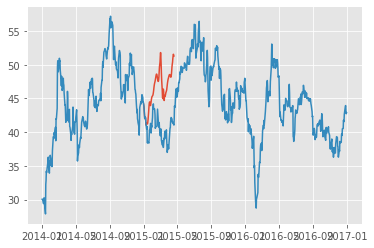

In [ ]:
plt.plot(pred_df)
plt.plot(df['2014':'2016'])

# Simple LSTM

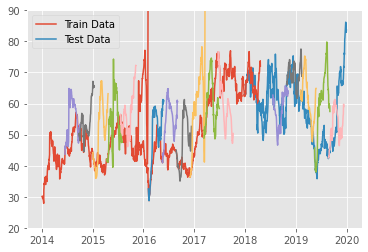

In [ ]:
def predictEveryNPeriods(model, data, N, input_length, future_steps, scaler):
  timestep = data.index.min()
  while timestep<data.index.max() - timedelta(days=input_length+future_steps):
    input_seq = data[timestep:timestep+timedelta(days=input_length)]
    pred = scaler.inverse_transform(np.expand_dims(predict(model, input_seq, future_steps=future_steps),0))[0]
    pred_date_range = pd.date_range(timestep,periods=len(pred))
    pred_df = pd.DataFrame(data={'Predictions':pred}, index=pred_date_range)
    plt.plot(pred_df)

    timestep += timedelta(days=N)
  pass

plt.plot(train_data['Adj Close'],label = 'Train Data')
plt.plot(test_data['Adj Close'],label = 'Test Data')
predictEveryNPeriods(model, train_data_scaled['Scaled_close'],100,input_length,100, scaler)
predictEveryNPeriods(model, test_data_scaled['Scaled_close'],100,input_length,100, scaler)
plt.ylim([20,90])
plt.legend()

# Bidirectional LSTM

In [ ]:
# Birectional
input_length  

model_bidirectional = tf.keras.models.Sequential()
model_bidirectional.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(input_length, n_features)))
model_bidirectional.add(tf.keras.layers.Dense(1))
model_bidirectional.compile(optimizer='adam', loss='mse')

In [ ]:
X_data, y_data = ConvertToKerasLagged(train_data_scaled, input_length, n_features )

In [94]:
model_bidirectional.fit(X_data, y_data, epochs=3000, shuffle=True,verbose=1)

Streaming output truncated to the last 5000 lines.
Epoch 501/3000
36/36 [==============================] - 0s 10ms/step - loss: 2.4674e-04
Epoch 502/3000
36/36 [==============================] - 0s 10ms/step - loss: 2.3379e-04
Epoch 503/3000
36/36 [==============================] - 0s 9ms/step - loss: 2.2552e-04
Epoch 504/3000
36/36 [==============================] - 0s 9ms/step - loss: 2.5202e-04
Epoch 505/3000
36/36 [==============================] - 0s 9ms/step - loss: 2.6650e-04
Epoch 506/3000
36/36 [==============================] - 0s 9ms/step - loss: 2.8129e-04
Epoch 507/3000
36/36 [==============================] - 0s 10ms/step - loss: 2.7643e-04
Epoch 508/3000
36/36 [==============================] - 0s 9ms/step - loss: 2.8494e-04
Epoch 509/3000
36/36 [==============================] - 0s 9ms/step - loss: 2.9837e-04
Epoch 510/3000
36/36 [==============================] - 0s 9ms/step - loss: 2.5669e-04
Epoch 511/3000
36/36 [==============================] - 0s 9ms/step - loss: 

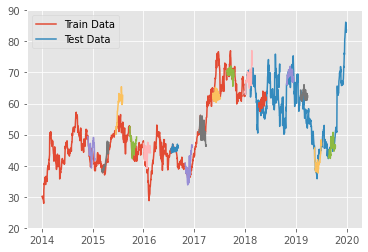

In [96]:

plt.plot(train_data['Adj Close'],label = 'Train Data')
plt.plot(test_data['Adj Close'],label = 'Test Data')
predictEveryNPeriods(model_bidirectional, train_data_scaled['Scaled_close'],100,input_length,40, scaler)
predictEveryNPeriods(model_bidirectional, test_data_scaled['Scaled_close'],100,input_length,40, scaler)
plt.ylim([20,90])
plt.legend()

# Stacked LSTM

In [ ]:

model_stacked = tf.keras.models.Sequential()
model_stacked.add(tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(input_length, n_features)))
model_stacked.add(tf.keras.layers.LSTM(50, activation='relu'))
model_stacked.add(tf.keras.layers.Dense(1))
model_stacked.compile(optimizer='adam', loss='mse')

In [90]:
X_data, y_data = ConvertToKerasLagged(train_data_scaled, input_length, n_features )
model_stacked.fit(X_data, y_data, epochs=3000, shuffle=True,verbose=1)

Epoch 1/3000
36/36 [==============================] - 0s 11ms/step - loss: 3.9811e-04
Epoch 2/3000
36/36 [==============================] - 0s 11ms/step - loss: 3.8758e-04
Epoch 3/3000
36/36 [==============================] - 0s 11ms/step - loss: 3.6882e-04
Epoch 4/3000
36/36 [==============================] - 0s 10ms/step - loss: 3.7490e-04
Epoch 5/3000
36/36 [==============================] - 0s 10ms/step - loss: 3.7464e-04
Epoch 6/3000
36/36 [==============================] - 0s 10ms/step - loss: 3.8371e-04
Epoch 7/3000
36/36 [==============================] - 0s 11ms/step - loss: 3.3755e-04
Epoch 8/3000
36/36 [==============================] - 0s 10ms/step - loss: 3.4141e-04
Epoch 9/3000
36/36 [==============================] - 0s 11ms/step - loss: 3.5406e-04
Epoch 10/3000
36/36 [==============================] - 0s 10ms/step - loss: 3.4980e-04
Epoch 11/3000
36/36 [==============================] - 0s 11ms/step - loss: 3.3944e-04
Epoch 12/3000
36/36 [==============================]

KeyboardInterrupt: ignored

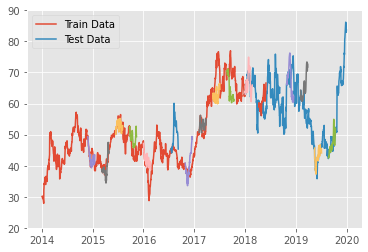

In [93]:
plt.plot(train_data['Adj Close'],label = 'Train Data')
plt.plot(test_data['Adj Close'],label = 'Test Data')
predictEveryNPeriods(model_stacked, train_data_scaled['Scaled_close'],100,input_length,40, scaler)
predictEveryNPeriods(model_stacked, test_data_scaled['Scaled_close'],100,input_length,40, scaler)
plt.ylim([20,90])
plt.legend()